In [1]:
import os
import random
import tarfile
import sys
import cv2
import time
import tensorflow as tf
from IPython.display import clear_output
from scipy import ndimage
import numpy as np
from six.moves.urllib.request import urlretrieve
import matplotlib.pyplot as plt
%matplotlib inline

### Downloading Files

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'

def download(filename):
    destination_file = "data/" + filename
    if not os.path.exists(destination_file):
        print("Dowloading ", filename, "into ", destination_file)
        urlretrieve(url + filename, destination_file)
    else:
        print "File already exists: %s" %filename
    return destination_file

def untar(filename):
    folder = filename.split(".tar")[0]
    if os.path.isdir(folder):
        print("%s already extracted" %filename)
    else:
        print("Extracting %s, please wait" %filename)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall("data")
        tar.close()
    extracted_folders = [
        os.path.join(folder, subfolder) for subfolder in sorted(os.listdir(folder))
        if os.path.isdir(os.path.join(folder, subfolder))]
    print(extracted_folders)
    return extracted_folders

data_filename = download('notMNIST_small.tar.gz')
data_folders = untar(data_filename)
print "Untar Finished"


File already exists: notMNIST_small.tar.gz
data/notMNIST_small.tar.gz already extracted
['data/notMNIST_small/A', 'data/notMNIST_small/B', 'data/notMNIST_small/C', 'data/notMNIST_small/D', 'data/notMNIST_small/E', 'data/notMNIST_small/F', 'data/notMNIST_small/G', 'data/notMNIST_small/H', 'data/notMNIST_small/I', 'data/notMNIST_small/J']
Untar Finished


### Reviewing data

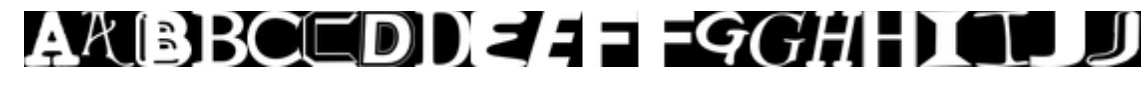

Maximum pixel intensity value: 255.00
Shape of images (28, 28)


In [3]:
# display a two random image from each letter in the train folder
def print_images(folders):
    images = []
    for folder in folders:
        images_path = os.listdir(folder)
        for i in range(2):
            image_path = os.path.join(folder,
                                      random.choice(images_path))
            images.append(ndimage.imread(image_path))
#             images.append(plt.imread(image_path))
#             images.append(cv2.imread(image_path))
    plt.figure(figsize=(20, 1))
    plt.imshow(np.hstack(images), cmap = 'gray')
    plt.axis('off')
    plt.show()
    print 'Maximum pixel intensity value: %.2f' %np.amax(images[0])
    print 'Shape of images ' + str(images[0].shape) 

print_images(data_folders)

### Building the dataset

In [4]:
image_size = 28
num_images_per_class = 1500

def number_of_images(folders):
    
    dataset = np.ndarray((num_images_per_class * 10, image_size, image_size), dtype=np.float32)
    labels = np.ndarray(num_images_per_class * 10, dtype=np.int32)
    num_per_class = {}
    counter = 0
    for image_class, folder in enumerate(folders):
        per_class_counter = 0
        for image_name in os.listdir(folder):
            if per_class_counter < num_images_per_class:
                image_path = os.path.join(folder, image_name)
                try:
                    image = ndimage.imread(image_path).astype(float)
                    image = (image - np.max(image) / 2) / np.max(image)
                    if image.shape == (image_size, image_size):
                        dataset[counter, :, :] = image
                        labels[counter] = image_class
                        counter += 1
                        per_class_counter += 1
                    else:
                        raise Exception("Unexpected image shape")
                except Exception as e:
                    print 'Unable to use image: ' + str(e)
        num_per_class[image_class] = per_class_counter
    return num_per_class, dataset, labels

num_per_class, dataset, labels = number_of_images(data_folders)
print 'Total number of images: %d' %dataset.shape[0]
print 'Number of images per class:'
print num_per_class
images_per_class = np.amin(num_per_class.values())
print 'We take %d images per class' %images_per_class
print 'Images Shape:' + str(dataset[0].shape)

Unable to use image: cannot identify image file 'data/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png'
Unable to use image: cannot identify image file 'data/notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png'
Total number of images: 15000
Number of images per class:
{0: 1500, 1: 1500, 2: 1500, 3: 1500, 4: 1500, 5: 1500, 6: 1500, 7: 1500, 8: 1500, 9: 1500}
We take 1500 images per class
Images Shape:(28, 28)


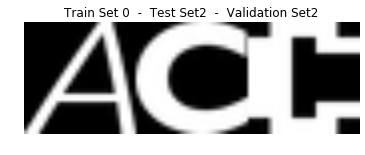

In [11]:
train_size = 1000
valid_size = 250
test_size = 250

train_dataset = np.ndarray((train_size * 10, image_size, image_size), dtype=np.float32)
train_labels = np.ndarray(train_size * 10, dtype=np.int32)

valid_dataset = np.ndarray((valid_size * 10, image_size, image_size), dtype=np.float32)
valid_labels = np.ndarray(valid_size * 10, dtype=np.int32)

test_dataset = np.ndarray((test_size * 10, image_size, image_size), dtype=np.float32)
test_labels = np.ndarray(test_size * 10, dtype=np.int32)

for i in range(10):
    
    start_set, end_set = i * num_images_per_class, (i + 1) * num_images_per_class
    start_train, end_train = i * train_size, (i + 1) * train_size
    start_valid, end_valid = i * valid_size, (i + 1) * valid_size
    start_test, end_test = i * test_size, (i + 1) * test_size
    
    letter_set = dataset[start_set : end_set, :, :]
    np.random.shuffle(letter_set)
    
    train_dataset[start_train : end_train, :, :] = letter_set[0: train_size, :, :]
    train_labels[start_train : end_train] = i
    valid_dataset[start_valid : end_valid, :, :] = letter_set[train_size: train_size + valid_size, :, :]
    valid_labels[start_valid : end_valid] = i
    test_dataset[start_test : end_test, :, :] = letter_set[train_size + valid_size: train_size + valid_size + test_size, :, :]
    test_labels[start_test : end_test] = i

plt.imshow(test_dataset[2300], cmap='gray')
    
    
for i in np.random.randint(0, 2500, 10):
    clear_output(wait="Ture")
    plt.imshow(np.hstack((train_dataset[i, :, :], test_dataset[i, :, :], valid_dataset[i, :, :])), cmap = 'gray')
    plt.title("Train Set " + str(train_labels[i]) + 
              "  -  Test Set" + str(test_labels[i]) + 
              "  -  Validation Set" + str(valid_labels[i]))
    plt.axis('off')
    plt.show()
    time.sleep(1)

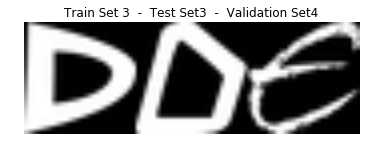

In [12]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

for i in np.random.randint(0, 2500, 10):
    clear_output(wait="Ture")
    plt.imshow(np.hstack((train_dataset[i, :, :], test_dataset[i, :, :], valid_dataset[i, :, :])), cmap = 'gray')
    plt.title("Train Set " + str(train_labels[i]) + 
              "  -  Test Set" + str(test_labels[i]) + 
              "  -  Validation Set" + str(valid_labels[i]))
    plt.axis('off')
    plt.show()
    time.sleep(1)

In [13]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

def reformat(dataset, labels):
    # as.type is not needed as the array is already float32 but just in case
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print("Train Shapes --> Dataset: %s   Labels: %s" %(train_dataset.shape, train_labels.shape))
print("Valid Shapes --> Dataset: %s   Labels: %s" %(valid_dataset.shape, valid_labels.shape))
print("Test Shapes  --> Dataset: %s   Labels: %s" %(test_dataset.shape, test_labels.shape))

Train Shapes --> Dataset: (10000, 28, 28, 1)   Labels: (10000, 10)
Valid Shapes --> Dataset: (2500, 28, 28, 1)   Labels: (2500, 10)
Test Shapes  --> Dataset: (2500, 28, 28, 1)   Labels: (2500, 10)


In [14]:
def accuracy(predictions, labels):
    return 100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0]

In [27]:
batch_size = 50
patch_size = 5
depth1 = 16
depth2 = 32
num_hidden = 64

graph = tf.Graph()

with graph.as_default():
    
    #Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    patch1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1))
    patch1_biases = tf.Variable(tf.zeros([depth1]))
    
    patch2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1))
    patch2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
    
    # divided by four because that is the size once the patches have scanned the image
    layer1_weights = tf.Variable(tf.truncated_normal(
                                 [image_size // 4 * image_size // 4 * depth2, num_hidden], stddev=0.1))
    layer1_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer2_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    # Model
    def model(data, training):
        # first convolution layer. Stride only matter in two elements in the middle
        conv1 = tf.nn.conv2d(data, patch1_weights, [1, 1, 1, 1], padding="SAME")
        conv1 = tf.nn.relu(conv1 + patch1_biases)
        conv1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1], padding="SAME" )
        
        # second convolution layer
        conv2 = tf.nn.conv2d(conv1, patch2_weights, [1, 1, 1, 1], padding="SAME")
        conv2 = tf.nn.relu(conv2 + patch2_biases)
        conv2 = tf.nn.max_pool(conv2, [1, 2, 2, 1], [1, 2, 2, 1], padding="SAME" )

        # reshape to apply fully connected layer
        shape_conv = conv2.get_shape().as_list()
        input_hidden = tf.reshape(conv2, [shape_conv[0], shape_conv[1] * shape_conv[2] * shape_conv[3]])
        hidden_layer = tf.nn.relu(tf.matmul(input_hidden, layer1_weights) + layer1_biases)
        
        # adding dropout layer
        if training:
            hidden_layer = tf.nn.dropout(hidden_layer, 0.6)
        
        return tf.matmul(hidden_layer, layer2_weights) + layer2_biases
    
    # training computation
    logits = model(tf_train_dataset, True)
    regularization = tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
           .0005 * regularization
    
    # Optimizer
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 200, 0.95, staircase = True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, False))
    test_prediction = tf.nn.softmax(model(tf_test_dataset, False))
    

In [30]:
num_steps = 2001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        # randomize offset
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 5.718042
Minibatch accuracy: 12.0%
Validation accuracy: 10.0%
Minibatch loss at step 500: 0.626355
Minibatch accuracy: 88.0%
Validation accuracy: 87.7%
Minibatch loss at step 1000: 0.686225
Minibatch accuracy: 84.0%
Validation accuracy: 90.6%
Minibatch loss at step 1500: 0.504949
Minibatch accuracy: 94.0%
Validation accuracy: 91.5%
Minibatch loss at step 2000: 0.599503
Minibatch accuracy: 84.0%
Validation accuracy: 92.2%
Test accuracy: 92.2%
